In [40]:
from astropy import units as u
from astropy import time

import numpy as np

from poliastro import iod
from poliastro.bodies import Mars, Earth, Jupiter, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [41]:
#starship specs
isp = 380
dry_mass = 100
prop_mass = 1200 #tons
lmo_fuel = 250


landing_reserve = 500

starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
boiloff = 0#0 

#for a skimpy 100t starship, only need 20 tons of landing fuel
print(isp*9.81*math.log((120)/(100)))



679.658299416504


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"



Ejection is with 6039m/s of DV (in sun reference frame, so actual number is different)
departure from Mars (♂) on 2035-07-02 00:02:09.185
arrival at Earth (♁) on 2035-09-30 00:02:09.185


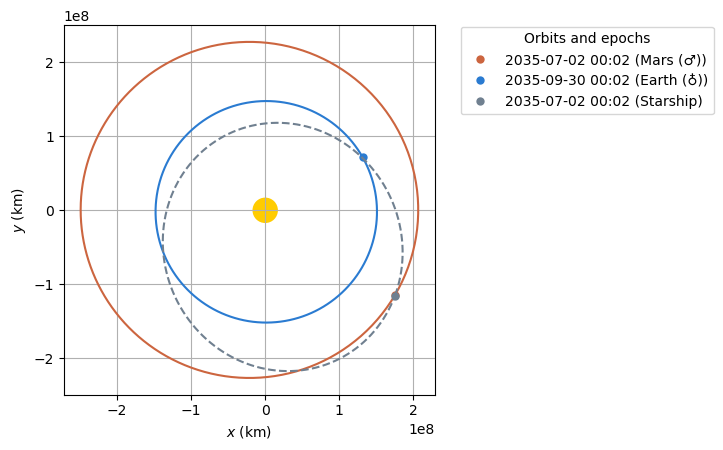

In [42]:

#launch from body_1 to body_2
body_1 = Mars
body_2 = Earth


#starship specs
isp = 380
dry_mass = 163
prop_mass = 1500
landing_reserve = 500
if(body_2 == Earth):
    landing_reserve = 300#less DV needed for Earth landing

starship_dv = isp*9.81*math.log((dry_mass+prop_mass)/dry_mass)
boiloff = 0#0 




#solve for a minimum ejection DV given a time period
transitTime = 90*u.day
resolution = 1*u.day
start_date = time.Time("2034-06-01 00:01", scale="utc").tdb
end_date = time.Time("2036-07-01 00:01", scale="utc").tdb

ephem_1 = Ephem.from_body(body_1, time_range(start_date, end=end_date+transitTime))
ephem_2 = Ephem.from_body(body_2, time_range(start_date, end=end_date+transitTime))


delta_time = end_date-start_date
lowest_dv = 100000
lowest_date = 0
lowest_orb = 0
for i in range(int(delta_time/resolution)):
    date_launch = start_date+i*resolution
    date_arrival = start_date+transitTime+i*resolution
    # Solve for departure and target orbits
    ss_planet_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)
    ss_planet_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)

    # Solve for the transfer maneuver
    man_lambert = Maneuver.lambert(ss_planet_1, ss_planet_2)
    ejection = man_lambert[0]
    dv = np.linalg.norm(ejection[1].value)
    if(dv<lowest_dv):
        lowest_dv=dv
        lowest_date = date_launch
        lowest_orb,final = ss_planet_1.apply_maneuver(man_lambert, intermediate=True)


reserve_dv = starship_dv-int(lowest_dv)-landing_reserve
#print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection is with {int((1-boiloff)*lowest_dv)}m/s of DV (in sun reference frame, so actual number is different)")
#print(f"Reserve DV (not accounting for boiloff) is {reserve_dv}m/s")
print(f"departure from {body_1} on {lowest_date}")
print(f"arrival at {body_2} on {lowest_date+transitTime}")
      
dM = 0*u.day

fig, ax = plt.subplots()

ax.grid(True)
#ax.set_title("2033 90 day trajectory")

# We can check new bodies positions
plotter = StaticOrbitPlotter(ax)
ss_leave_1 = Orbit.from_ephem(Sun, ephem_1, lowest_date)
ss_arrival_2 = Orbit.from_ephem(Sun, ephem_2, lowest_date+transitTime)

plotter.plot_body_orbit(body_1,  lowest_date+dM, label=body_1)

plotter.plot_body_orbit(body_2,  lowest_date+dM+transitTime, label=body_2)
label_str = lowest_date.datetime.strftime("%Y-%m-%d")


#plotter.plot(ss_leave_1, label=label_str)

plotter.plot(lowest_orb, color="slategrey", label="Starship")

In [43]:
#calculate total boiloff during trip
starship_albedo = 0.1
#approxing solar irradiance with tanh between body 1 and body 2
def sig_rad(dT):
    return (math.exp(dT)-math.exp(-dT))/(math.exp(dT)+math.exp(-dT))



In [44]:
#Find SOI change on departure
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_1 = Orbit.from_ephem(Sun, ephem_1, date_launch)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_1.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_1.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference>0):
        print(f"Departure at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Departed SOI on {soi_change_point}")



9300 steps
Departure at step7
Departed SOI on 2035-07-02 01:42:57.185


Soi change at 132747.2079645865 km (potentially seems low tbf)
C3 is 36.609104416063175 km2 / s2
Starship DV is 8658.293696167946m/s
Ejection velocity is 7.795106779472077 km / s
Ejection DV is 4.319866839028514 km / s
Starship has 4038.4268571394314 m / s of DV after the burn excluding landing reserve (500 m/s)


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"



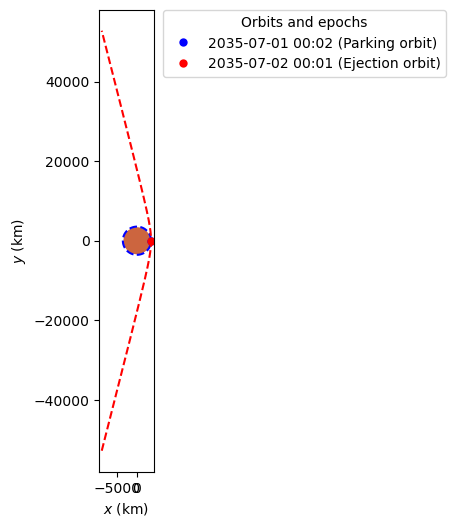

In [45]:
ss_final = lowest_orb.propagate(soi_change_point-date_launch) 


r_body_1, v_body_1 = ss_body_1.r,ss_body_1.v
r_sc_arriv = ss_final.r-r_body_1
v_sc_arriv = ss_final.v-v_body_1
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 150*u.km#parking orbit

parking_orbit = Orbit.circular(body_1,alt = r_p,epoch = date_launch-1*u.day)


a_exit = -(body_1.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_1.R) / a_exit

departure_orbit = Orbit.from_classical(
    body_1,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_launch, scale="utc"),
)
print(f"Starship DV is {starship_dv}m/s")   
print(f"Ejection velocity is {np.linalg.norm(departure_orbit.v)}")
print(f"Ejection DV is {np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)}")
ejection_dv = (np.linalg.norm(departure_orbit.v)-np.linalg.norm(parking_orbit.v)).value
reserve_dv = starship_dv-(ejection_dv*1000)-landing_reserve
print(f"Starship has {reserve_dv} m / s of DV after the burn excluding landing reserve (500 m/s)")

earth_plotter = StaticOrbitPlotter()

earth_plotter.plot(parking_orbit, label="Parking orbit", color="b")
earth_plotter.plot(departure_orbit, label="Ejection orbit", color="r")


In [46]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
#ss_earth = Orbit.from_ephem(Sun, earth, date_launch)

#arrival body is body 2
ss_body_2 = Orbit.from_ephem(Sun, ephem_2, date_arrival)


#calculate SOI crossing point
ss_transfer = lowest_orb
ss_final = lowest_orb
time_sliver = 0.01*u.day
steps = int(((transitTime+3*u.day)/time_sliver).value)
print(f"{steps} steps")
soi_change_point = lowest_date+transitTime
for i in range(steps):
    ss_final = ss_transfer.propagate(i*time_sliver)
    arrival_distance = np.linalg.norm(ss_final.r-ss_body_2.r)
    #print(earth_distance)
    grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-body_2.mass/((arrival_distance)**2)
    #print(grav_difference)
    if(grav_difference<0):
        print(f"arrival at step{i}")
        soi_change_point = date_launch+i*time_sliver
        break


print(f"Normal arrival would be {date_arrival}")
print(f"Actual arrival at {soi_change_point}")



9300 steps
arrival at step8991
Normal arrival would be 2035-09-30 00:02:09.185
Actual arrival at 2035-09-29 21:52:33.185


Soi change at 245126.36918705993 km (potentially seems low tbf)
C3 is 79.73781489292855 km2 / s2
New periapsis is -50.192870594698434 kmkm
Arrival speed (at periapsis) would be 14.25409173973103 km / s
After deacceleration burn it is 10.771257714424397 km / s
Entry C3 is -9.961039586306585 km^2/s^2
Need to lose -0.4086174652941512 km / s in initial aerocapture pass


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\erfa\core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



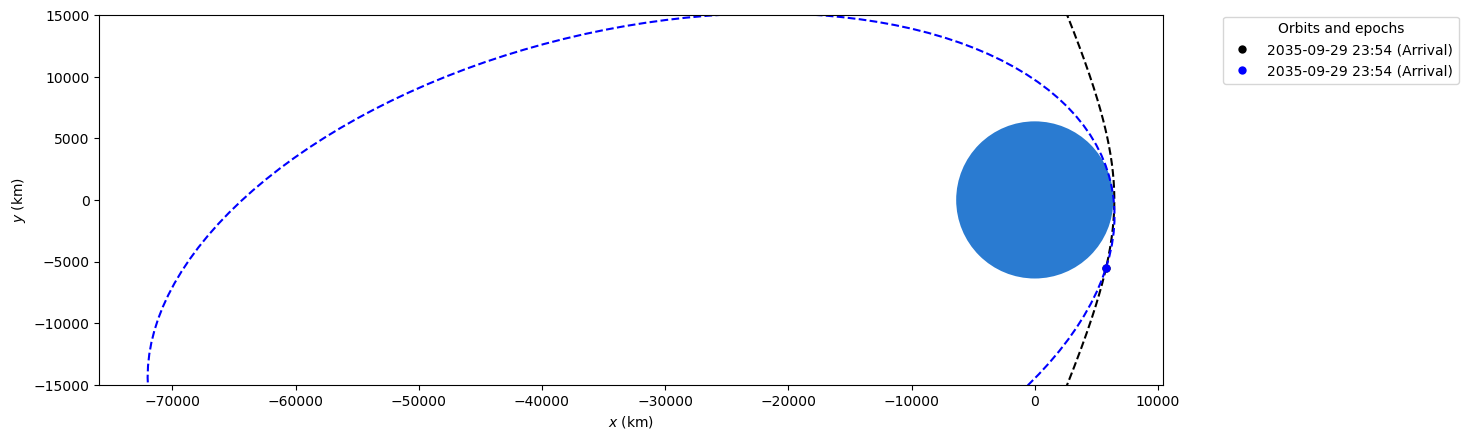

In [47]:
#ITS BROKEN AND I UNDERSTAND WHY



retro_time = 400*u.second #how long before entry interface to do the retro burn

ss_final = lowest_orb.propagate(soi_change_point-date_launch) 


r_body_2, v_body_2 = ss_body_2.r,ss_body_2.v
r_sc_arriv = ss_final.r-r_body_2
v_sc_arriv = ss_final.v-v_body_2
c3_a = np.linalg.norm(v_sc_arriv)**2
print(f"Soi change at {np.linalg.norm(r_sc_arriv)} (potentially seems low tbf)")
print(f"C3 is {c3_a}")


#C3 only orbit calc
r_p = 80*u.km#arrival periapsis
a_exit = -(body_2.k / c3_a).to(u.km)
ecc_exit = 1 - (r_p+body_2.R) / a_exit

arrival_orbit = Orbit.from_classical(
    body_2,
    a_exit,
    ecc_exit,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,
    0 * u.deg,  # We don't mind
    time.Time(date_arrival, scale="utc"),
)


pre_burn_orbit = arrival_orbit.propagate(-retro_time)
#perform the retro burn
prograde_vector = (pre_burn_orbit.v/(np.linalg.norm(pre_burn_orbit.v))).value
#offset by a little as we dont want periapsis going into the atmosphere
rad_vector = (pre_burn_orbit.r/(np.linalg.norm(pre_burn_orbit.r))).value
rad_offset_weight = 0.27
retro_vector = -(prograde_vector-rad_offset_weight*rad_vector)
retro_vector = retro_vector/np.linalg.norm(retro_vector)

# print(prograde_vector)


##no deaccleration burn for arriving at Earth for now


burn_dv = 0.001*reserve_dv*(retro_vector)
#print(burn_dv)
# else:
#     burn_dv = 0*prograde_vector

retro_burn = Maneuver((0*u.s,burn_dv*u.km/u.s))
#retro_burn = Maneuver((0*u.s,[0,1,0]*u.km/u.s))
post_burn_orbit = pre_burn_orbit.apply_maneuver(retro_burn)

print(f"New periapsis is {post_burn_orbit.r_p-body_2.R}km")

ax = plt.gca()       # or plotter.ax if you stored it directly
ax.set_ylim([-1.5e4, 1.5e4]) 

earth_plotter = StaticOrbitPlotter(ax)

#print(f"State vectors post burn are {post_burn_orbit.r} and {post_burn_orbit.v}.")



earth_plotter.plot(pre_burn_orbit, label="Arrival", color="k")
earth_plotter.plot(post_burn_orbit, label="Arrival", color="b")
#earth_plotter.

# print(post_burn_orbit.v)
# print(post_burn_orbit.r)

post_burn_orbit = post_burn_orbit.propagate(-post_burn_orbit.t_p)
arrival_circular_orbit = Orbit.circular(body_2,alt = 200*u.km)


print(f"Arrival speed (at periapsis) would be {np.linalg.norm(arrival_orbit.v)}")
print(f"After deacceleration burn it is {np.linalg.norm(post_burn_orbit.v)}")
#post_burn_c3 = ((np.linalg.norm(post_burn_orbit.v)-(body_2.escape_velocity()))**2)

post_burn_c3 = -(body_2.k/(post_burn_orbit.a.to(u.m))).value/1000000
print(f"Entry C3 is {post_burn_c3} km^2/s^2")


print(f"Need to lose {np.linalg.norm(post_burn_orbit.v)-body_2.escape_velocity()} in initial aerocapture pass")

####code below tries to calculate real orbit, but patched conics problems force a c3 only calculation orbit tbf

# #grav_difference = Sun.mass/(np.linalg.norm(ss_final.r)**2)-Earth.mass/(np.linalg.norm(r_sc_arriv)**2)
# print(grav_difference)

# arrival_orbit = Orbit.from_vectors(Earth,r_sc_arriv,v_sc_arriv,epoch=date_arrival-offset_time)
# #arrival_orbit = arrival_orbit.propagate(0.3*u.day)
# print(arrival_orbit)
# print(f"This orbit gets to within {arrival_orbit.r_p-Earth.R} of the surface of earth")
# print(f"Earth position at {lowest_date}")

# earth_plotter = StaticOrbitPlotter()

# earth_plotter.plot(arrival_orbit, label="earth Arrival", color="k")



In [48]:
#for the optimized trajectory, re get the epherimis
date_launch = lowest_date
date_arrival = lowest_date+transitTime
ss_earth = Orbit.from_ephem(Sun, earth, date_launch)
ss_mars = Orbit.from_ephem(Sun, mars, date_arrival)




#ejection from Earth
#calculate departure orbit
prop_time = 0.012*u.day

ss_leave = lowest_orb.propagate(prop_time)
r_earth,v_earth=ss_earth.r,ss_earth.v
r_traj_leave = ss_leave.r-r_earth
v_traj_leave = ss_leave.v-v_earth


ejection_orbit = Orbit.from_vectors(Earth,r_traj_leave,v_traj_leave,epoch = date_launch)
#ejection_orbit.inc = 0*u.rad
#propogate ejection_orbit to periapsis



parking_orbit = Orbit.circular(Earth,inc=0*u.rad, alt=300 << u.km,epoch = date_launch)



print(ejection_orbit.energy)# = 0*u.rad
print(parking_orbit.energy)

#calculate ejection DV
#print(parking_orbit.v)
dE = ejection_orbit.energy-parking_orbit.energy
dV=np.sqrt(dE)
print(f"Ejection DV is {dV}")


print(parking_orbit)
print(ejection_orbit)
earth_ejection_plotter = StaticOrbitPlotter()

ejection_orbit.inc = 0*u.rad
earth_ejection_plotter.plot(parking_orbit, label="Parking Orbit", color="b")
earth_ejection_plotter.plot(ejection_orbit, label="Ejection Orbit", color="k")

NameError: name 'earth' is not defined